# Use Pre-Trained Model

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import tomli
import matplotlib.pyplot as plt
from os import environ
from pathlib import Path
from buildings_bench import load_torch_dataset
from buildings_bench.models import model_factory

/global/homes/n/nrushad/.conda/envs/BuildingsBenchEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class DataHandler:
    def __init__(self): pass

    def load_dataset(self, dataset_name, scaler_transform):
        dataset = load_torch_dataset(
            name=dataset_name,
            apply_scaler_transform=scaler_transform,
            scaler_transform_path=Path(environ["TRANSFORM_PATH"])
        )
        return dataset

    def create_dataloader(self, building_dataset):
        dataloader = torch.utils.data.DataLoader(
                        building_dataset,
                        batch_size=360,
                        shuffle=False)
        return dataloader

In [4]:
class Model:

    class BuildingsBenchTransformer:
        def __init__(self):pass

        def load_model(self, model_name, device):
            tomli_args = tomli.load(open(environ["CONFIG_PATH"],'rb'))
            model_args = tomli_args['model']
            model, _, predict = model_factory(model_name, model_args)
            context_len = model.context_len
            model = model.to(device)
            model = model.load_from_checkpoint(Path(environ["CHECKPOINT_PATH"]))
            return model, predict, context_len

In [5]:
def main(model_name, dataset_name, scaler_transform, device):
    handler = DataHandler()
    dataset = handler.load_dataset(dataset_name, scaler_transform)    

    BuildingsBenchTransformer = Model.BuildingsBenchTransformer()
    model, predict, context_len = BuildingsBenchTransformer.load_model(model_name, device)

    target_list = []
    prediction_list = []
    
    for building_id, building_dataset in dataset:
        
        inverse_transform = building_dataset.datasets[0].load_transform.undo_transform
        dataloader = handler.create_dataloader(building_dataset)
        
        for batch in dataloader:
            for key, value in batch.items():
                batch[key] = value.to(device)

            with torch.cuda.amp.autocast(enabled=(device == 'cuda:0')):
                predictions, _ = predict(batch)
        
            targets = batch['load'][:, context_len:]
            targets = inverse_transform(targets)
            target_list.append(targets.detach().cpu())
            
            predictions = inverse_transform(predictions)
            prediction_list.append(predictions.detach().cpu())

    prediction_list = torch.cat(prediction_list)
    target_list = torch.cat(target_list)
    
    return prediction_list, target_list

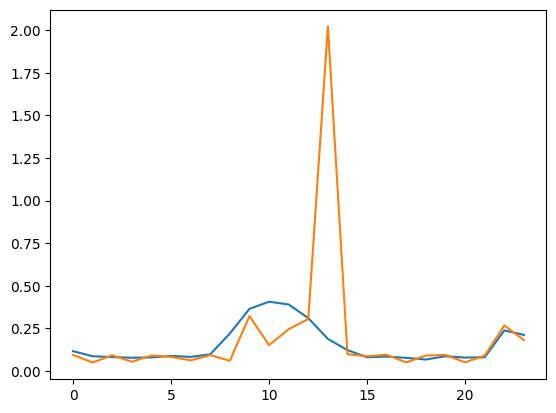

In [8]:
if __name__ == "__main__":

    DATASET = 'ideal' # Electricity | SMART | Ideal | lcl
    DEVICE = 'cuda:0'
    MODEL = 'TransformerWithGaussian-L' # TransformerWithGaussian-S | TransformerWithGaussian-M
    CHECKPOINT = 'Transformer_Gaussian_L.pt'
    SCALER_TRANSFORM = 'boxcox'

    PATH = '/pscratch/sd/n/nrushad'
    environ["PATH"] = PATH
    
    environ["REPO_PATH"] = f'{PATH}/BuildingsBenchTutorial/BuildingsBench/'
    environ["CONFIG_PATH"] = f'{PATH}/BuildingsBenchTutorial/BuildingsBench/buildings_bench/configs/{MODEL}.toml'
    environ["BUILDINGS_BENCH"] = f'{PATH}/Dataset'
    environ["TRANSFORM_PATH"] = f'{PATH}/Dataset/metadata/transforms'

    environ["CHECKPOINT_PATH"] = f'{PATH}/checkpoints/{CHECKPOINT}'
    
    prediction_list, target_list = main(MODEL, DATASET, SCALER_TRANSFORM, DEVICE)
    plt.plot(prediction_list[0].squeeze())
    plt.plot(target_list[0].squeeze())